In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import pystan

In [2]:
# Can be exchanged to simple/complex.
df = pd.read_csv("simple.csv")
df.head()

,X1,X2,Y
0,-0.626454,0.409402,0.679195
1,0.183643,1.688873,1.331719
2,-0.835629,1.586588,-0.075450
3,1.595281,-0.330908,0.981765
4,0.329508,-2.285236,0.465314


In [ ]:
# Compile simple model Stanmodel
sm = pystan.StanModel(model_code="""
    data{
      int<lower=0> N;
      vector[N] X1;
      vector[N] Y;
    }
    parameters{
      real a;
      real b1;
      real<lower=0> sigma;
    }
    model{
      Y ~ normal(a + b1 * X1 , sigma);
    }
    """)

# Compile complex model:
cm = pystan.StanModel(model_code="""
    data{
      int<lower=0> N;
      vector[N] X1;
      vector[N] X2;
      vector[N] Y;
    }
    parameters{
      real a;
      real b1;
      real b2;
      real<lower=0> sigma;
    }
    model{
      Y ~ normal(a + b1 * X1 + b2 * X2, sigma);
    }
    """)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7d9fa3ac74c499a4ca124d01dd249d58 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4145ba9a7db66ace45c7512a26675e6e NOW.


In [ ]:
error_simple = []
error_complex = []

folds = 10

# Folds
for fold in range(0, folds):
    # Splitting data set.
    test = df[(df.index % folds) == fold]
    train = df[(df.index % folds) != fold]

    # Fit the simple model.
    fit = sm.sampling(data={"N": len(train), "Y": train["Y"], "X1": train["X1"]}, iter=4000, chains=1)
    samples = fit.extract()

    # Shame on us not taking the complete posterior.
    a = samples["a"].mean()
    b1 = samples["b1"].mean()

    # Prediction.
    Ypred = a + b1 * test["X1"]

    error_simple.append(sum([pow(x, 2) for x in Ypred - test["Y"]]))

    # Fit the complex model.
    fit = cm.sampling(data={"N": len(train), "Y": train["Y"], "X1": train["X1"], "X2": train["X2"]}, iter=4000, chains=1)
    samples = fit.extract()

    # Shame on us not taking the complete posterior.
    a = samples["a"].mean()
    b1 = samples["b1"].mean()
    b2 = samples["b2"].mean()

    # Prediction.
    Ypred = a + b1 * test["X1"] + b2 * test["X2"]

    error_complex.append(sum([pow(x, 2) for x in Ypred - test["Y"]]))

# What remains to be done is comparing the collected errors
# ...

(array([1., 1., 3., 0., 3., 0., 1., 0., 0., 1.]),
 array([1.909928  , 2.37799287, 2.84605773, 3.3141226 , 3.78218747,
        4.25025233, 4.7183172 , 5.18638207, 5.65444693, 6.1225118 ,
        6.59057667]),
 <a list of 10 Patch objects>)

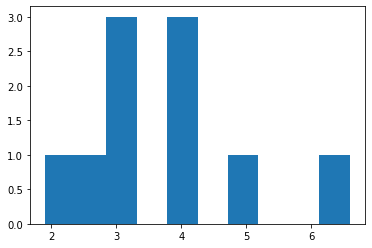

In [ ]:
plt.hist(error_simple)

(array([1., 2., 2., 0., 3., 0., 1., 0., 0., 1.]),
 array([1.94958226, 2.42659789, 2.90361352, 3.38062914, 3.85764477,
        4.3346604 , 4.81167602, 5.28869165, 5.76570728, 6.2427229 ,
        6.71973853]),
 <a list of 10 Patch objects>)

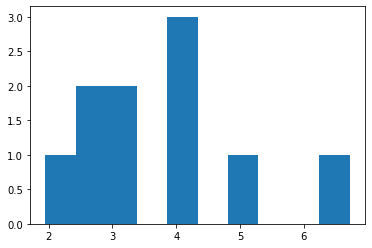

In [ ]:
plt.hist(error_complex)